In [2]:
# Importing some shizzle.

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import time
import requests
import datetime
import sys
import os
import pathlib
import seaborn as sns
from sklearn.metrics import roc_auc_score
import math
from utilities import perform_stats, calc_z_scores

location = 'rjsietsma'

read_loc = '/home/'+location+'/shared/'
data_expor_loc = '/home/'+location+'/Documents/School/Master_DSLS/Final_Thesis/Past_initial_data/'

img_output_dir = '/home/'+location+'/PycharmProjects/dsls_master_thesis/side_scripts/output_img/'

In [3]:
# Read in the data
full_snv_dataset = pd.read_csv(read_loc+'full_dataset.csv')
full_snv_dataset

,chr,pos,ref,alt,label,gene,consequence,capice,source
0,14,68196054,GCCCTG,G,LP/P,RDH12,FRAME_SHIFT,0.988552,train
1,20,10626717,TCA,T,LP/P,JAG1,STOP_GAINED,0.990329,train
2,20,10625898,CTG,C,LP/P,JAG1,FRAME_SHIFT,0.991696,train
3,20,10628741,AC,A,LP/P,JAG1,FRAME_SHIFT,0.983607,train
4,20,10625509,ACT,A,LP/P,JAG1,DOWNSTREAM,0.987999,train
...,...,...,...,...,...,...,...,...,...
456004,17,29556342,G,A,LP/P,NF1,SYNONYMOUS,0.000139,test
456005,11,5248177,A,T,LP/P,HBB,SYNONYMOUS,0.069934,test
456006,15,48787324,T,C,LP/P,FBN1,SYNONYMOUS,0.909190,test
456007,19,17947957,G,A,LP/P,JAK3,SYNONYMOUS,0.001238,test


In [6]:
def identify_incorrect_genes():
    possibly_incorrect_genes = pd.DataFrame(columns=['chr', 'pos', 'ref', 'alt', 'gene', 'correct_chr'])

    done = 0
    total = full_snv_dataset['gene'].unique().shape[0]
    reset_timer = time.time()
    for gene in full_snv_dataset['gene'].unique():
        time_ifl = time.time()
        if time_ifl - reset_timer > 10:
            print(f'Still busy, done: {round(done/total*100, ndigits=2)}%')
            reset_timer = time.time()
        subset_ds = full_snv_dataset[full_snv_dataset['gene'] == gene]
        if subset_ds['chr'].unique().shape[0] > 1:
            print(f'Gene {gene} lies on multiple chromosomes!: {subset_ds["chr"].unique()}')
            value_counts = subset_ds['chr'].value_counts()
            print(value_counts)
            possibly_incorrect_index = value_counts.sort_values().index[0]
            correct_index = value_counts.sort_values().index[1]
            print(subset_ds[subset_ds['chr'] == possibly_incorrect_index])
            exclude_genes = ['Y-RNA', 'snoU13', 'Y_RNA',
                             'SNORA43', 'SNORA73', 'U3', 'U6']
            if gene not in exclude_genes:
                incorrect_chr = subset_ds[subset_ds['chr'] == str(possibly_incorrect_index)]['chr'].values
                pos = subset_ds[subset_ds['chr'] == str(possibly_incorrect_index)]['pos'].values
                ref = subset_ds[subset_ds['chr'] == str(possibly_incorrect_index)]['ref'].values
                alt = subset_ds[subset_ds['chr'] == str(possibly_incorrect_index)]['alt'].values
                output = pd.DataFrame({'chr':incorrect_chr,
                                       'pos':pos,
                                       'ref':ref,
                                       'alt':alt,
                                       'gene': gene, 
                                       'correct_chr': str(correct_index)},
                                      index=[0])
                possibly_incorrect_genes = possibly_incorrect_genes.append(output, ignore_index=True)
        done += 1
    return possibly_incorrect_genes


In [4]:
# possibly_incorrect_genes = identify_incorrect_genes()
# possibly_incorrect_genes.to_csv(read_loc+'VKGL_incorrect_annotated_snvs_14nov2019.txt', sep='\t', index=False)

In [5]:
subset_ds = full_snv_dataset[full_snv_dataset['gene'] == 'RYR1']
subset_ds['chr'].unique()[0]

'19'

# Conclusion: dataset is not clean!
now it is

In [4]:
full_mapped_ds = pd.read_csv(read_loc+'optimal_f1_full_ds_v2.csv', header=0)
full_mapped_ds.sort_values(by='default_f1', ascending=False)

,gene,default_auc,default_f1,default_recall,default_fpr,default_spec,optimal_c,optimal_auc,optimal_f1,optimal_recall,optimal_fpr,optimal_spec,n_tot,n_benign,n_malign
2775,PRKN,1.000000,1.0,1.0,0.0,1.0,0.020,1.000000,1.000000,1.0,0.0,1.0,11,7,4
1659,BUB1B,1.000000,1.0,1.0,0.0,1.0,0.020,1.000000,1.000000,1.0,0.0,1.0,73,66,7
2102,GALNT3,1.000000,1.0,1.0,0.0,1.0,0.020,1.000000,1.000000,1.0,0.0,1.0,12,10,2
1655,PNPLA1,1.000000,1.0,1.0,0.0,1.0,0.020,1.000000,1.000000,0.8,0.2,0.8,31,26,5
2782,TMEM80,1.000000,1.0,1.0,0.0,1.0,0.020,1.000000,1.000000,1.0,0.0,1.0,5,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2625,C10orf2,0.469697,0.0,0.0,1.0,0.0,0.020,0.469697,0.000000,0.0,1.0,0.0,133,132,1
2330,SPTLC2,0.455157,0.0,0.0,1.0,0.0,0.011,0.750374,0.170213,0.0,1.0,0.0,229,223,6
2615,PLCD1,0.500000,0.0,0.0,1.0,0.0,0.020,0.500000,0.000000,0.0,1.0,0.0,8,7,1
2611,UBE2A,0.500000,0.0,0.0,1.0,0.0,0.020,0.500000,0.000000,0.0,1.0,0.0,3,2,1


In [3]:
filter1 = full_mapped_ds['n_benign'] > 5
filter2 = full_mapped_ds['n_malign'] > 5
filter3 = full_mapped_ds['n_tot'] > 100

full_mapped_ds.where(filter1 & filter2 & filter3).dropna().sort_values(by='default_auc', ascending=True).head(10)

,gene,default_auc,default_f1,default_recall,default_fpr,default_spec,optimal_c,optimal_auc,optimal_f1,optimal_recall,optimal_fpr,optimal_spec,n_tot,n_benign,n_malign
2330,SPTLC2,0.455157,0.000000,0.000000,1.000000,0.000000,0.011,0.750374,0.170213,0.000000,1.000000,0.000000,229.0,223.0,6.0
2376,SCARB1,0.487032,0.000000,0.000000,1.000000,0.000000,0.020,0.487032,0.000000,0.000000,1.000000,0.000000,355.0,347.0,8.0
2455,GARS,0.561587,0.120000,0.230769,0.769231,0.230769,0.016,0.630599,0.175439,0.230769,0.769231,0.230769,329.0,316.0,13.0
2399,MUT,0.578992,0.075949,0.428571,0.571429,0.428571,0.010,0.724650,0.102564,0.428571,0.571429,0.428571,262.0,255.0,7.0
2442,SCN10A,0.598381,0.250000,0.200000,0.800000,0.200000,0.023,0.598785,0.266667,0.200000,0.800000,0.200000,1245.0,1235.0,10.0
110,CYP7A1,0.646646,0.300000,0.352941,0.647059,0.352941,0.018,0.703715,0.372093,0.352941,0.647059,0.352941,302.0,285.0,17.0
1269,PCSK9,0.657343,0.313725,0.363636,0.636364,0.363636,0.020,0.657343,0.313725,0.340909,0.659091,0.340909,902.0,858.0,44.0
271,STAP1,0.680432,0.260870,0.428571,0.571429,0.428571,0.024,0.688244,0.300000,0.428571,0.571429,0.428571,199.0,192.0,7.0
429,COL18A1,0.702941,0.538462,0.411765,0.588235,0.411765,0.019,0.761765,0.642857,0.411765,0.588235,0.411765,357.0,340.0,17.0
1135,PDE11A,0.704272,0.196721,0.857143,0.142857,0.857143,0.035,0.807076,0.307692,0.857143,0.142857,0.857143,114.0,107.0,7.0


In [7]:
for consequence in full_snv_dataset['consequence'].unique():
    print(f'Consequence: {consequence}')
    print(full_snv_dataset[full_snv_dataset['consequence'] == consequence]['label'].value_counts())
    

Consequence: FRAME_SHIFT
LP/P    17804
LB/B     8069
Name: label, dtype: int64
Consequence: STOP_GAINED
LP/P    14842
LB/B     4458
Name: label, dtype: int64
Consequence: DOWNSTREAM
LB/B    22319
LP/P     1224
Name: label, dtype: int64
Consequence: CANONICAL_SPLICE
LP/P    5788
LB/B    2817
Name: label, dtype: int64
Consequence: INTRONIC
LB/B    61132
LP/P      620
Name: label, dtype: int64
Consequence: INFRAME
LB/B    4053
LP/P     824
Name: label, dtype: int64
Consequence: SPLICE_SITE
LB/B    8092
LP/P     839
Name: label, dtype: int64
Consequence: REGULATORY
LB/B    13540
LP/P      874
Name: label, dtype: int64
Consequence: 3PRIME_UTR
LB/B    688
LP/P     11
Name: label, dtype: int64
Consequence: UPSTREAM
LB/B    14500
LP/P      958
Name: label, dtype: int64
Consequence: NONCODING-CHANGE
LB/B    1113
LP/P       2
Name: label, dtype: int64
Consequence: NON_SYNONYMOUS
LB/B    62811
LP/P    19845
Name: label, dtype: int64
Consequence: NONCODING_CHANGE
LB/B    592
LP/P     82
Name: labe

In [9]:
subset_genes = full_mapped_ds[full_mapped_ds['default_auc'] < 0.6]['gene']

In [10]:
def export_genelist(dataframe, filename):
    dataframe.to_csv(data_expor_loc + filename + '.csv', header=False, index=False)

In [11]:
export_genelist(subset_genes, 'Genes_AUC_lower_60')

In [12]:
full_mapped_ds[full_mapped_ds['gene'] == 'APOL1']
# APOL1
# Get full list of metabolic & liver diseases

,gene,default_auc,default_f1,default_recall,default_fpr,default_spec,optimal_c,optimal_auc,optimal_f1,optimal_recall,optimal_fpr,optimal_spec,n_tot,n_benign,n_malign
2685,APOL1,0.5,0.0,0.0,1.0,0.0,0.02,0.5,0.0,0.0,1.0,0.0,106,102,4


<AxesSubplot:>

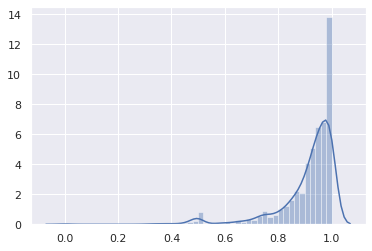

In [5]:
sns.set();np.random.seed(0)
sns.distplot(np.array(full_mapped_ds['default_auc']))

In [6]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from impute_preprocess import ImputePreprocess
import scipy

In [7]:
cadd_vars = ['Ref', 'Alt', 'Type', 'Length','GC', 'CpG', 'motifECount', 'motifEScoreChng', 'motifEHIPos',
           'oAA', 'nAA', 'cDNApos', 'relcDNApos', 'CDSpos', 'relCDSpos', 'protPos', 'relProtPos', 'Domain', 'Dst2Splice',
           'Dst2SplType', 'minDistTSS', 'minDistTSE', 'SIFTcat', 'SIFTval', 'PolyPhenCat', 'PolyPhenVal', 'priPhCons',
           'mamPhCons', 'verPhCons', 'priPhyloP', 'mamPhyloP', 'verPhyloP', 'bStatistic', 'targetScan', 'mirSVR-Score',
           'mirSVR-E', 'mirSVR-Aln', 'cHmmTssA', 'cHmmTssAFlnk', 'cHmmTxFlnk', 'cHmmTx', 'cHmmTxWk', 'cHmmEnhG',
           'cHmmEnh', 'cHmmZnfRpts', 'cHmmHet', 'cHmmTssBiv', 'cHmmBivFlnk', 'cHmmEnhBiv', 'cHmmReprPC', 'cHmmReprPCWk',
           'cHmmQuies', 'GerpRS', 'GerpRSpval', 'GerpN', 'GerpS', 'TFBS', 'TFBSPeaks', 'TFBSPeaksMax', 'tOverlapMotifs',
           'motifDist', 'Segway', 'EncH3K27Ac', 'EncH3K4Me1', 'EncH3K4Me3', 'EncExp', 'EncNucleo', 'EncOCC', 'EncOCCombPVal',
           'EncOCDNasePVal', 'EncOCFairePVal', 'EncOCpolIIPVal', 'EncOCctcfPVal', 'EncOCmycPVal', 'EncOCDNaseSig',
           'EncOCFaireSig', 'EncOCpolIISig', 'EncOCctcfSig', 'EncOCmycSig', 'Grantham', 'Dist2Mutation', 'Freq100bp',
           'Rare100bp', 'Sngl100bp', 'Freq1000bp', 'Rare1000bp', 'Sngl1000bp', 'Freq10000bp', 'Rare10000bp',
           'Sngl10000bp', 'dbscSNV-ada_score', 'dbscSNV-rf_score']

In [8]:
data = pd.read_csv('./datafiles/train.txt.gz', sep='\t', header=0, low_memory=False)
print(f'Data: \n{data.head()} \n')
print(f'Shape: \n{data.shape}')

Data: 
  #Chrom  Allergy/Immunology/Infectious Alt          AnnoType  \
0     14                          False   G  CodingTranscript   
1     20                          False   T  CodingTranscript   
2     20                          False   C  CodingTranscript   
3     20                          False   A  CodingTranscript   
4     20                          False   A        Intergenic   

   Audiologic/Otolaryngologic  Biochemical         CCDS  CDSpos  \
0                       False        False   CCDS9787.1   806.0   
1                        True        False  CCDS13112.1  1899.0   
2                        True        False  CCDS13112.1  2118.0   
3                        True        False  CCDS13112.1  1586.0   
4                        True        False          NaN     NaN   

   Cardiovascular              ConsDetail  ...  revel sift  source  \
0           False              frameshift  ...    NaN  NaN    vkgl   
1            True  frameshift,stop_gained  ...    NaN  NaN 

In [9]:
train, test = train_test_split(data, test_size = 0.2)

In [10]:
train.select_dtypes(include='bool').columns.tolist()
train_columns_unprocessed = train.columns

In [11]:
for x in train.columns:
    print(f'\n{x}\n{train[x].describe()}\n')


#Chrom
count     267680
unique        24
top            2
freq       31972
Name: #Chrom, dtype: object


Allergy/Immunology/Infectious
count     267680
unique         2
top        False
freq      246916
Name: Allergy/Immunology/Infectious, dtype: object


Alt
count     267680
unique      2530
top            T
freq       78240
Name: Alt, dtype: object


AnnoType
count               267680
unique                   5
top       CodingTranscript
freq                184968
Name: AnnoType, dtype: object


Audiologic/Otolaryngologic
count     267680
unique         2
top        False
freq      248421
Name: Audiologic/Otolaryngologic, dtype: object


Biochemical
count     267680
unique         2
top        False
freq      254461
Name: Biochemical, dtype: object


CCDS
count          247705
unique           7731
top       CCDS59435.1
freq            10928
Name: CCDS, dtype: object


CDSpos
count    185297.000000
mean       5892.982892
std       16040.569500
min           1.000000
25%         659


GerpRSpval
count     1.984200e+05
mean      4.908981e-02
std       1.544114e+01
min       0.000000e+00
25%      2.249130e-215
50%      1.107470e-111
75%       4.930280e-64
max       6.720000e+03
Name: GerpRSpval, dtype: float64


GerpS
count    267680.000000
mean          1.433312
std           4.228150
min         -12.300000
25%          -0.650000
50%           2.650000
75%           4.840000
max           6.170000
Name: GerpS, dtype: float64


Grantham
count    102465.000000
mean         72.714312
std          46.459216
min           0.000000
25%          29.000000
50%          64.000000
75%          99.000000
max         215.000000
Name: Grantham, dtype: float64


Hematologic
count     267680
unique         2
top        False
freq      247928
Name: Hematologic, dtype: object


Intron
count     47744
unique     3322
top         2/3
freq        371
Name: Intron, dtype: object


Length
count    267680.000000
mean          0.433077
std           2.783520
min           0.000000
25%     


cHmmTxFlnk
count    267680.000000
mean          0.008234
std           0.052946
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           0.969000
Name: cHmmTxFlnk, dtype: float64


cHmmTxWk
count    267680.000000
mean          0.229015
std           0.202270
min           0.000000
25%           0.063000
50%           0.181000
75%           0.354000
max           0.976000
Name: cHmmTxWk, dtype: float64


cHmmZnfRpts
count    267680.000000
mean          0.005421
std           0.029121
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           0.969000
Name: cHmmZnfRpts, dtype: float64


chr_pos_ref_alt
count              267680
unique             267680
top       1_160100204_C_T
freq                    1
Name: chr_pos_ref_alt, dtype: object


chr_pos_ref_alt_gene
count                        267680
unique                       267680
top       2_179460227_TACTTAC_T_TTN
freq                   


tOverlapMotifs
count    13544.000000
mean         1.808771
std          1.861931
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         36.000000
Name: tOverlapMotifs, dtype: float64


targetScan
count    444.000000
mean      81.513514
std       18.235661
min        8.000000
25%       75.000000
50%       88.000000
75%       95.000000
max       99.000000
Name: targetScan, dtype: float64


to_be_deleted
count     267680
unique         2
top        False
freq      264964
Name: to_be_deleted, dtype: object


verPhCons
count    267672.000000
mean          0.597285
std           0.460299
min           0.000000
25%           0.005000
50%           0.965000
75%           1.000000
max           1.000000
Name: verPhCons, dtype: float64


verPhyloP
count    267672.000000
mean          1.508912
std           2.284995
min          -9.086000
25%          -0.051000
50%           0.839000
75%           3.183000
max           6.421000
Name: verPhyloP, dtype

In [12]:
imputed_train = ImputePreprocess(verbose=False).impute(df=train)
train_preprocessed = ImputePreprocess(verbose=False).preprocess(imputed_train, isTrain=True)
# train_preprocessed = preprocess(impute(train), isTrain=True)

In [13]:
train_processed_columns = train_preprocessed.columns
for x in train_columns_unprocessed:
    if x not in train_processed_columns:
        print(x)

Alt
Domain
Dst2SplType
PolyPhenCat
Ref
SIFTcat
Segway
Type
nAA
oAA


In [14]:
train_preprocessed

,#Chrom,Allergy/Immunology/Infectious,AnnoType,Audiologic/Otolaryngologic,Biochemical,CCDS,CDSpos,Cardiovascular,ConsDetail,ConsScore,...,nAA_T,nAA_V,nAA_other,nAA_unknown,oAA_A,oAA_L,oAA_P,oAA_R,oAA_other,oAA_unknown
211764,1,False,CodingTranscript,False,False,CCDS929.1,370.0,True,missense,7.0,...,0,0,1,0,0,0,0,0,1,0
53891,16,False,Transcript,False,False,CCDS10539.1,0.0,False,intron,2.0,...,0,0,0,1,0,0,0,0,0,1
178552,16,False,CodingTranscript,False,False,CCDS10458.1,1911.0,True,synonymous,5.0,...,0,1,0,0,0,0,0,0,1,0
251808,1,False,RegulatoryFeature,False,False,NaN,0.0,False,regulatory,4.0,...,0,0,0,1,0,0,0,0,0,1
229136,3,False,Transcript,False,False,CCDS3078.1,0.0,False,intron,2.0,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122579,2,False,CodingTranscript,False,False,CCDS33172.1,3085.0,False,missense,7.0,...,0,0,1,0,0,0,1,0,0,0
304137,17,False,CodingTranscript,False,False,CCDS11156.1,3187.0,False,missense,7.0,...,0,0,1,0,0,0,0,0,1,0
152315,4,False,CodingTranscript,False,False,CCDS3702.1,4230.0,True,synonymous,5.0,...,0,0,1,0,0,0,0,1,0,0
117952,20,False,CodingTranscript,False,False,CCDS13201.1,3800.0,False,missense,7.0,...,0,0,1,0,0,0,0,0,1,0


In [15]:
processed_features = []
for col in train_preprocessed.columns:
    for feat in cadd_vars:
        if col == feat or col.startswith(feat):
            if col not in processed_features:
                processed_features.append(col)
for x in train_preprocessed[processed_features].columns:
    print(f'\n{x}\n{train_preprocessed[x].describe()}\n')


CDSpos
count    267680.000000
mean       4079.318780
std       13620.197302
min           0.000000
25%           0.000000
50%         735.000000
75%        2352.000000
max      107976.000000
Name: CDSpos, dtype: float64


CpG
count    267680.000000
mean          0.058627
std           0.060540
min           0.000000
25%           0.013333
50%           0.040000
75%           0.080000
max           0.481013
Name: CpG, dtype: float64


Dist2Mutation
count    267680.000000
mean        110.678982
std        1924.926078
min           0.000000
25%          15.000000
50%          27.000000
75%          46.000000
max      362790.000000
Name: Dist2Mutation, dtype: float64


Dst2Splice
count    267680.000000
mean          0.467465
std           5.868768
min         -20.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          20.000000
Name: Dst2Splice, dtype: float64


EncExp
count    267680.000000
mean        457.608233
std        3144.595154
min           0.000


cHmmEnhG
count    267680.000000
mean          0.020748
std           0.049494
min           0.000000
25%           0.000000
50%           0.000000
75%           0.016000
max           0.677000
Name: cHmmEnhG, dtype: float64


cHmmHet
count    267680.000000
mean          0.008957
std           0.037428
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           0.787000
Name: cHmmHet, dtype: float64


cHmmQuies
count    267680.000000
mean          0.278884
std           0.289331
min           0.000000
25%           0.024000
50%           0.173000
75%           0.480000
max           1.000000
Name: cHmmQuies, dtype: float64


cHmmReprPC
count    267680.000000
mean          0.023827
std           0.076243
min           0.000000
25%           0.000000
50%           0.000000
75%           0.008000
max           0.913000
Name: cHmmReprPC, dtype: float64


cHmmReprPCWk
count    267680.000000
mean          0.072923
std           0.121158
min      


Ref_G
count    267680.000000
mean          0.300945
std           0.458670
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: Ref_G, dtype: float64


Ref_T
count    267680.000000
mean          0.157774
std           0.364530
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: Ref_T, dtype: float64


Ref_other
count    267680.000000
mean          0.071873
std           0.258278
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: Ref_other, dtype: float64


SIFTcat_UD
count    267680.000000
mean          0.643754
std           0.478890
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: SIFTcat_UD, dtype: float64


SIFTcat_deleterious
count    267680.000000
mean          0.178926
std           0.383291
min         

In [16]:
test_imputed = ImputePreprocess(verbose=False).impute(test)
test_preprocessed = ImputePreprocess(verbose=False).preprocess(test_imputed, isTrain=False, model_features=processed_features)

In [17]:
eval_set = [(test_preprocessed[processed_features], test_preprocessed['binarized_label'], 'test')]

In [18]:
model_findEstimator = xgb.XGBClassifier(verbosity=2,
                                            objective='binary:logistic', booster='gbtree', n_jobs=8,
                                            min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1,
                                            colsample_bylevel=1, colsample_bynode=1, reg_alpha=0, reg_lambda=1,
                                            scale_pos_weight=1, base_score=0.5, random_state=0)

In [19]:
param_dist = {
        'max_depth': scipy.stats.randint(1, 20),  # (random integer from 1 to 20)
        'learning_rate': scipy.stats.expon(scale=0.06),  # (random double from an exponential with scale 0.06)
        'n_estimators': scipy.stats.randint(100, 600),  # (random integer from 10 to 600)
    }

In [20]:
ransearch1 = RandomizedSearchCV(estimator=model_findEstimator, param_distributions=param_dist,
                                    scoring='roc_auc', n_jobs=8, iid=False, cv=5, n_iter=20, verbose=10)

In [29]:
# ransearch1.fit(train_preprocessed[processed_features], train_preprocessed['binarized_label'],
#                    early_stopping_rounds=15, eval_metric=["auc"], eval_set=eval_set, verbose=True,
#                    sample_weight=train_preprocessed['sample_weight'])

In [30]:
# plt.violinplot(np.array(train_preprocessed[processed_features]))
# plt.show()

In [31]:
train_preprocessed[processed_features].describe()

,CDSpos,CpG,Dist2Mutation,Dst2Splice,EncExp,EncH3K27Ac,EncH3K4Me1,EncH3K4Me3,EncNucleo,EncOCC,...,nAA_T,nAA_V,nAA_other,nAA_unknown,oAA_A,oAA_L,oAA_P,oAA_R,oAA_other,oAA_unknown
count,267680.000000,267680.000000,267680.000000,267680.000000,267680.000000,267680.000000,267680.000000,267680.000000,267680.000000,267680.000000,...,267680.000000,267680.000000,267680.000000,267680.000000,267680.000000,267680.000000,267680.000000,267680.000000,267680.000000,267680.000000
mean,4079.318780,0.058627,110.678982,0.467465,457.608233,10.479036,7.086858,12.993520,1.371127,3.956183,...,0.046492,0.045203,0.492670,0.308787,0.056512,0.051020,0.050254,0.068668,0.464745,0.308802
std,13620.197302,0.060540,1924.926078,5.868768,3144.595154,61.143270,9.130040,45.010873,0.952102,1.436296,...,0.210549,0.207750,0.499947,0.461994,0.230907,0.220039,0.218469,0.252889,0.498756,0.462000
min,0.000000,0.000000,0.000000,-20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.013333,15.000000,0.000000,6.210130,2.800000,2.000000,2.000000,0.700000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,735.000000,0.040000,27.000000,0.000000,55.977200,4.000000,4.000000,3.000000,1.300000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2352.000000,0.080000,46.000000,0.000000,193.521000,6.720000,7.840000,5.000000,1.900000,5.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,107976.000000,0.481013,362790.000000,20.000000,181308.000000,12874.000000,274.000000,4553.000000,62.200000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
train_data = np.array(train_preprocessed[processed_features])
train_data = calc_z_scores(train_data)
corr_matrix = (train_data.T @ train_data) / (train_data.shape[0] - 1)

In [36]:
# plt.violinplot(train_data)
# plt.show()

In [37]:
# train_data = np.array(train_preprocessed[processed_features])
# corr_matrix = (train_data.T @ train_data) / (train_data.shape[0] - 1)

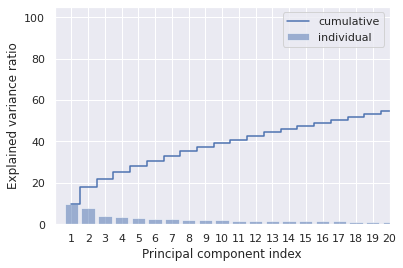

In [26]:
eigenvalues, eigenvectors = np.linalg.eig(corr_matrix)
# order = eigenvalues.argsort()[::-1]
# eigenvalues = eigenvalues[order]
# eigenvectors = eigenvectors[:, order]

# calculate cumulative sum of explained variances
tot = sum(eigenvalues)
var_exp = [(i / tot * 100) for i in sorted(eigenvalues, reverse=True)]
cum_var_exp = np.cumsum(var_exp)


# plot explained variances
plt.bar(range(1,eigenvalues.size + 1), var_exp, alpha=0.5,
        align='center', label='individual')
plt.step(range(1,eigenvalues.size + 1), cum_var_exp, where='mid',
         label='cumulative')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.xticks(np.arange(1, 21), np.arange(1, 21))
plt.legend(loc='best')
plt.xlim((0,20))
plt.show()

pd.DataFrame(
    {
        'PC': range(1,eigenvalues.size + 1),
        'Var_expl.': var_exp,
        'Cum_var_expl.': cum_var_exp
    }
).to_csv('./not_saving_directory/pc_overview.csv', sep=',', index=False)

In [27]:
print(temp)

     cum_var_expl
1        9.816845
2       17.804582
3       21.851585
4       25.287332
5       28.155804
..            ...
127    100.000000
128    100.000000
129    100.000000
130    100.000000
131    100.000000

[131 rows x 1 columns]


In [39]:
train_preprocessed.columns
# Perform PCA on only the numerical columns, not the categorical.

Index(['#Chrom', 'Allergy/Immunology/Infectious', 'AnnoType',
       'Audiologic/Otolaryngologic', 'Biochemical', 'CCDS', 'CDSpos',
       'Cardiovascular', 'ConsDetail', 'ConsScore',
       ...
       'nAA_T', 'nAA_V', 'nAA_other', 'nAA_unknown', 'oAA_A', 'oAA_L', 'oAA_P',
       'oAA_R', 'oAA_other', 'oAA_unknown'],
      dtype='object', length=191)

In [40]:
def project_pca(projections, cum_var_exp, max_var_exp=None, max_pc=None, export=False):
    if not max_var_exp and not max_pc:
        raise AttributeError('At least one of maximum variance explained or maximum of principal components must be given.')
    if not max_var_exp:
        iterative_max = cum_var_exp.size
    else:
        iterative_max = cum_var_exp[cum_var_exp < max_var_exp].size - 1 
    curr_var_exp = 0
    PC1 = 0
    PC2 = 1
    color = 2
    iteration = 1
    for not_used_variable in range(iterative_max):
        if max_pc:
            if PC1 > max_pc:
                break
        curr_var_exp = cum_var_exp[iteration-1]
        plt.scatter(projections[:,PC1], projections[:,PC2], c=projections[:,color], s=1)
        plt.title(f'PCA PC1: {PC1}, PC2: {PC2}, var_exp: {round(curr_var_exp, ndigits=0)}')
        PC1 = color
        PC2 = PC1+1
        color = PC2+1
        iteration += 1
        plt.show()
    im_title = f'{datetime.datetime.now().strftime("%Y_%m_%d_%H%M%S_%f")}_PCA_projections_capturing_{max_var_exp}_variance'
    if export:
        image_name = img_output_dir+im_title+'.png'
        plt.savefig(image_name)
    plt.show()
    

In [33]:
projections = train_data @ eigenvectors

In [42]:
# project_pca(projections, cum_var_exp, max_pc=20)

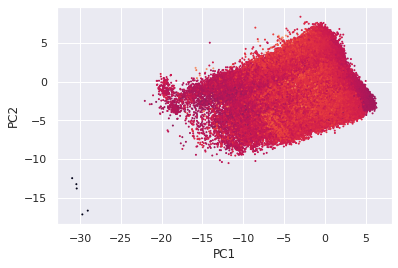

In [39]:
plt.scatter(projections[:,0], projections[:,1], c=projections[:, 2], s=1)
# Color by label
# Pairwise 
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [44]:
def varimax(components, gamma=1, maxiter=20, tol=1e-8):
    """Perform VariMax (gamma=1) or OrthoMax (gamma=0) rotation on components"""
    p,k = components.shape
    R   = np.eye(k)
    f   = float(gamma)/p
    d   = 0
    for i in range(maxiter):
        d_old = d
        L = np.dot(components, R)
        A = L**3 - f * (L*(L**2).sum(axis=0))**2
        U,s,V = np.linalg.svd(np.dot(components.T,A))
        R = np.dot(U,V)
        d = sum(s)
        if (d - d_old)**2 < tol: 
            break
    return np.dot(components, R)

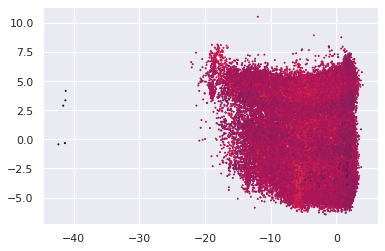

In [45]:
# Perform Factor Analysis on PCA
V = varimax(eigenvectors[:,:3])
fa_projections = train_data @ V
plt.scatter(fa_projections[:,0], fa_projections[:,1], c=fa_projections[:, 2], s=1)
plt.show()

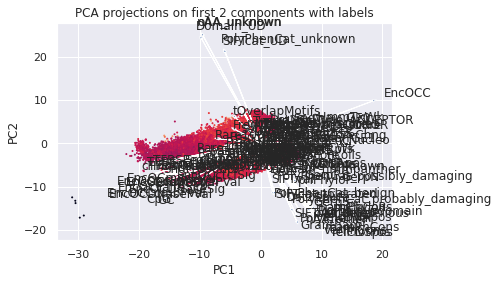

In [38]:
# Biplot showing projections and directions of original variables

start = 0

stop = len(train_preprocessed[processed_features].columns)

ncol = stop - start

variables = train_preprocessed[processed_features].columns[start:stop]

plt.scatter(projections[:,0], projections[:,1], c=projections[:, 2], s=1)
for i, (var, (x,y)) in enumerate(zip(variables, 100*eigenvectors[:, :2])):
    x = np.real(x)
    y = np.real(y)
    if i < ncol:
        plt.arrow(0, 0, x, y, head_width=0.5)
        plt.text(1.1*x, 1.1*y, var)
plt.title('PCA projections on first 2 components with labels')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [47]:
start = 0
stop = 10
for x in range(13):
    print(train_preprocessed[processed_features].columns[start:stop+1])
    start = stop
    stop += 10

Index(['CDSpos', 'CpG', 'Dist2Mutation', 'Dst2Splice', 'EncExp', 'EncH3K27Ac',
       'EncH3K4Me1', 'EncH3K4Me3', 'EncNucleo', 'EncOCC', 'EncOCCombPVal'],
      dtype='object')
Index(['EncOCCombPVal', 'EncOCDNasePVal', 'EncOCDNaseSig', 'EncOCFairePVal',
       'EncOCFaireSig', 'EncOCctcfPVal', 'EncOCctcfSig', 'EncOCmycPVal',
       'EncOCmycSig', 'EncOCpolIIPVal', 'EncOCpolIISig'],
      dtype='object')
Index(['EncOCpolIISig', 'Freq10000bp', 'Freq1000bp', 'Freq100bp', 'GC',
       'GerpN', 'GerpRS', 'GerpRSpval', 'GerpS', 'Grantham', 'Length'],
      dtype='object')
Index(['Length', 'PolyPhenVal', 'Rare10000bp', 'Rare1000bp', 'Rare100bp',
       'SIFTval', 'Sngl10000bp', 'Sngl1000bp', 'Sngl100bp', 'TFBS',
       'TFBSPeaks'],
      dtype='object')
Index(['TFBSPeaks', 'TFBSPeaksMax', 'bStatistic', 'cDNApos', 'cHmmBivFlnk',
       'cHmmEnh', 'cHmmEnhBiv', 'cHmmEnhG', 'cHmmHet', 'cHmmQuies',
       'cHmmReprPC'],
      dtype='object')
Index(['cHmmReprPC', 'cHmmReprPCWk', 'cHmmTssA', 'cHmm

# Notes meeting 24-03-2020
- Get all genes that perform bad from the histograms earlier in this notebook
- Add FPR, recall, sensitivity and specificity to mapper function
- Add vkgl and test data to optimum AUC mapper
- *see school bookmark for gene panels* calculate auc and compare auc's
    - Immunodeficiency (big chunk)
    - Developmental delay
    - 5GPM everything except late onset, but is very large
    - More popular panels will have more information, possibly easier to interpret.
 - Phase 1:
     - Make a list of biases and other easy to test statistics per gene / chromosome
     - Grab genes that are difficult to predict and label them.
     - Apply (NaN)GMLVQ on (to predict) to show correlations / causations.


[google docs](https://docs.google.com/document/d/1D5SiNbeDEfY2hTWquS88MGUrLv6IgZzfCzflppRGb5k/edit) of what is interesting

To add onto the idea of novel annotations, below are some of the ideas I find interesting:
- pLI (loss of intolerance)
- Popmax filtering AF (we might be already using it in benchmarking but I guess there is no harm in explicitly testing it?)
- [pext](https://www.biorxiv.org/content/10.1101/554444v1)
- [Enhancer features](https://www.sciencedirect.com/science/article/abs/pii/S0002929720300124)
- Features included in this [paper](https://www.nature.com/articles/s41467-019-13212-3)

Interesting papers:

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6369448/

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5618255/ (supplement 5)



# Notes on training data on GCC cluster
- Some gene panels seem to be included
    - Allergy/Immunology/Infectious
    - Audiologic/Otolaryngologic
    - Biochemical
    - Cardiovascular
    - Craniofacial (facial bones)
    - Dermatologic
    - Endocrine
    - Gastrointestinal
    - Genitourinary
    - Hematologic
    - Musculoskeletal
    - Neurologic
    - Obstetric
    - Oncologic
    - Ophthalmologic
    - Pulmonary
    - Renal
        - Documentation is key, that shows when I looked up the training script.
        - CAPICE on github could use some per method documentation.
        - __Origin of these panels is the Clinical Genomic Database (CGD)__
- Some really unclear columns are in the real training data:
    - General
    - inTest (is just False)
- Lots of commented out lines of code.

From the umcg-sli/variant_prioritization/data:
    - train_results.txt seems to be the same, somewhat.
    - train.txt doesn't seem at all what I have.
    - test_results seems to be the same somewhat.

Looking in past-paper:
    - test_results is a bit more detailed on cluster.
    - Same for train_results.
    - train.txt is the same as in /data.
    
Take home note: Ask Shuang what needs to happen if I want to retrain the model from scratch.
 - step4_xgboost_finetune_hyperparameters_sklearnWrapper.py
 - impute_preprocess.py
 
I'm able to retrain the model from scratch I think.
 

# Investigate:
- What was used in CADD to make that top of the line at that time?
    - Or just CADD just a search engine that searches the Alt through different pathogenicity predictors?

- CADD already takes into account the phylogenetic tree.
    - But not how new a gene is within the human race
- CADD is a logistic regression model
- Shuang mentioned that RawScore and PHRED are not used in CAPICE, so can I conclude that CAPICE is sort of a CADD 2.0?
- What is known about the genes that do not perform well and what is known about the genes that do perform well?


__do not forget: make presentation before thursday 12:00 about project__

# Notes EOS 02-04-2020

- Voor Sander: als je op een pubmed ID klikt, ga je naar molgenis.gcc.rug.nl/pubmedID waar een abstract te lezen is van die pubmed ID... (Is te schrijven in Python, heb ik ervaring mee)
- Voor Sander, als het nog geen feature request, verander diseased C nummer met de titel van de hyperlink.

Mine 

- Investigate whenever genes that do not perform well are in multiple gene panels
- Possible reduced penetrance in genes that do not perform well
- Pathways perform better or worse
- Number of pathogenic variants per 1000 (or something) bases (normalizing the variants per gene)


# Notes 08-04-2020
- Shuang has made it very devious on the preprocessing and imputing part. I get the imputing part, but also I don't. You impute the CADD variables, keep some of the others stock. Some columns even have 99% missing values, making thus 99% of those datapoints scewed.

# Notes 14-04-2020
- Training dataset is very complex, such that the first 2 components only explain 18% of the variance. 
- Also, variance between columns in training data is large. Maybe try training CAPICE again with normalized train data?

# Notes 16-04-2020
- Inform Dennis about findings on double CAPICE scores.
- Maybe help Sander to build a web scraper in python to get the abstracts?

# Notes PRO 16-04-2020
- Take a bad performing gene, that is well represented, look what pathways it is in and then investigate further.
    - Keep it close to molecular level (so not pain, but like metabolism).
        - __Maybe currently: metabolic < neurotic < everything else in terms of performance.__
        - SPTLC2, arguably one of the worst performing genes, has no categorical "True" values. While YARS2, one of the best performing genes, has categorical True and False. Correlation?
        
- Lower threshold for bad performing genes in Enrichr (so 0.7 or lower), see if there are big changes.
    - Done, according to bioplanet 2019, there are some differences. Metabolic, lipid and lipoprotein metabolism is less enriched in genes with auc < 0.6. There's a lot more varriaty. According to KEGG, more cancer related genes are enriched in genes under 0.6, like melanoma, MAPK signaling pathway and breast cancer. But also neurotic related, like long term depression. If we then look at the cell types, Liver is the one that pops up most enriched, which isn't that different from a higher threshold (higher threshold has skeletal muscle and retina more enriched. Interestingly, CD14+ monocytes and cerebellum penducles are then enriched next for both thresholds. If we then look at the diseases/drugs, brugada syndrome (genetic abnormality of the heart) is most enriched in the lower threshold. Also HIV susceptibility seems to be higher. In summary: there's a much less clear image of one single tissue or molecular cohersion (?) (let's say, it's not all to pinpoint it to metabolism).
- Hypothesis: Performance of metabolic related genes in CAPICE are both in Enrichr and UMCG performing worse.
    - Could be false. In genes with an AUC lower than 0.6, a lot less metabolic related genes are enriched. They are still present though, but a lot less enriched. A lot more heart and mind related diseases pop up. 
- Find more features, look into dbSNFP.
    - dbSNFP done, only gain of function remains
- PCA: Find out what categorical data is.
- PCA: Redo PCA but without the categorical data
- PCA: which features are important to distinguis label 1 from label 2? __(Extra work, could be difficult to interpret, maybe leave label out first and check again later?)__
- Make CAPICE retrain script in preparation.
- CAPICE double scores are "solved", missing scores are not yet.
    - Precomputed scores are required for those that want to download a whole file containing each position with each alternative score.
    - Includes running CAPICE on the full CADD dataset
    - DO ON CLUSTER
        - Genome build version 37, CADD 1.4.
        - GIGANTIC dataset, read in parts.
- Help Sander on getting abstract for VIBE 3.x
    - Bonus points if I help Sander
        - It seems like Sander has some good ideas on getting the abstracts. Also there's some database licensing related issues.
- Look at representative gene

In [48]:
# Investigating gene panels
# data = full_mapped_ds

In [49]:
from bs4 import BeautifulSoup
import warnings

In [50]:
def get_ncbi_abstract(pmid):
    # Function for Sander if he decides to request it.
    # Do remember to build this function in a timer function so that not 1000000 requests get send at the same time.
    # Or just use entrez, is also possibility.
    url = 'https://www.ncbi.nlm.nih.gov/pubmed/'+pmid+'/'
    page_request = requests.get(url)
    page_request.close()
    soup = BeautifulSoup(page_request, 'html.parser')
    try:
        abstract = soup.find(class_='abstr').find('div').p.get_text()
        return abstract
    except AttributeError:
        warnings.warn(f'PMID {pmid} has no abstract or PMID is not available!')
    

In [51]:
start = 0
stop = 10
for x in range(15):
    print(data.columns[start:stop+1])
    start = stop
    stop += 10

Index(['#Chrom', 'Allergy/Immunology/Infectious', 'Alt', 'AnnoType',
       'Audiologic/Otolaryngologic', 'Biochemical', 'CCDS', 'CDSpos',
       'Cardiovascular', 'ConsDetail', 'ConsScore'],
      dtype='object')
Index(['ConsScore', 'Consequence', 'CpG', 'Craniofacial', 'Dental',
       'Dermatologic', 'Dist2Mutation', 'Domain', 'Dst2SplType', 'Dst2Splice',
       'EncExp'],
      dtype='object')
Index(['EncExp', 'EncH3K27Ac', 'EncH3K4Me1', 'EncH3K4Me3', 'EncNucleo',
       'EncOCC', 'EncOCCombPVal', 'EncOCDNasePVal', 'EncOCDNaseSig',
       'EncOCFairePVal', 'EncOCFaireSig'],
      dtype='object')
Index(['EncOCFaireSig', 'EncOCctcfPVal', 'EncOCctcfSig', 'EncOCmycPVal',
       'EncOCmycSig', 'EncOCpolIIPVal', 'EncOCpolIISig', 'Endocrine', 'Exon',
       'FeatureID', 'Freq10000bp'],
      dtype='object')
Index(['Freq10000bp', 'Freq1000bp', 'Freq100bp', 'GC', 'Gastrointestinal',
       'GeneID', 'GeneName', 'General', 'Genitourinary', 'GerpN', 'GerpRS'],
      dtype='object')
Index(['Ge

In [52]:
np.sort(data[data['Biochemical'] == True]['GeneName'].unique())

array(['AARS2', 'AASS', 'ABAT', 'ABCD1', 'ABCD3', 'ABCD4', 'ABCG5',
       'ABCG8', 'ABHD5', 'ACAD8', 'ACAD9', 'ACADM', 'ACADS', 'ACADSB',
       'ACADVL', 'ACAT1', 'ACOX1', 'ACSF3', 'ACY1', 'ADAMTSL2', 'ADK',
       'ADSL', 'AGA', 'AGK', 'AGL', 'AGPS', 'AGXT', 'AHCY', 'AIFM1',
       'ALAD', 'ALDH3A2', 'ALDH4A1', 'ALDH5A1', 'ALDH6A1', 'ALDOA',
       'ALDOB', 'ALG1', 'ALG11', 'ALG12', 'ALG2', 'ALG3', 'ALG6', 'ALG8',
       'ALG9', 'AMACR', 'AMPD1', 'AMT', 'APOPT1', 'APRT', 'ARG1', 'ARSA',
       'ARSB', 'ASAH1', 'ASL', 'ASNS', 'ASS1', 'ATAD3A', 'ATIC',
       'ATP6V0A2', 'ATP7A', 'ATP7B', 'ATPAF2', 'AUH', 'B4GALT1', 'BCHE',
       'BCKDHA', 'BCKDHB', 'BCKDK', 'BCS1L', 'BOLA3', 'BTD', 'CA5A',
       'CAD', 'CARS2', 'CBS', 'CD320', 'CHIT1', 'CLN3', 'CLN5', 'CLN6',
       'CLN8', 'CLPB', 'COA3', 'COA6', 'COG1', 'COG2', 'COG4', 'COG5',
       'COG6', 'COG7', 'COG8', 'COQ2', 'COQ4', 'COQ6', 'COQ7', 'COQ9',
       'COX10', 'COX14', 'COX15', 'COX20', 'COX6B1', 'CP', 'CPS1',
       'CPT1A', '

In [53]:
data[data['GeneName'] == 'SPTLC2']

,#Chrom,Allergy/Immunology/Infectious,Alt,AnnoType,Audiologic/Otolaryngologic,Biochemical,CCDS,CDSpos,Cardiovascular,ConsDetail,...,revel,sift,source,tOverlapMotifs,targetScan,to_be_deleted,verPhCons,verPhyloP,inTest,sample_weight
40261,14,False,A,CodingTranscript,False,False,CCDS9865.1,1145.0,False,missense,...,0.940,1.000,clinvar,NaN,NaN,False,1.000,5.865,False,0.8
51960,14,False,C,Transcript,False,False,CCDS9865.1,NaN,False,3_prime_UTR,...,NaN,NaN,clinvar,NaN,NaN,False,0.987,0.488,False,0.8
51961,14,False,A,CodingTranscript,False,False,CCDS9865.1,1664.0,False,missense,...,0.482,0.974,clinvar,NaN,NaN,False,0.999,3.758,False,1.0
51962,14,False,T,CodingTranscript,False,False,CCDS9865.1,1227.0,False,synonymous,...,0.018,0.000,clinvar,NaN,NaN,False,0.435,-0.795,False,1.0
51963,14,False,T,Transcript,False,False,CCDS9865.1,NaN,False,"splice,intron",...,NaN,NaN,clinvar,NaN,NaN,False,0.144,0.239,False,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330285,14,False,C,CodingTranscript,False,False,CCDS9865.1,1006.0,False,missense,...,0.803,0.999,unknown,NaN,NaN,False,1.000,2.315,False,0.8
330765,14,False,T,CodingTranscript,False,False,CCDS9865.1,565.0,False,missense,...,0.219,0.955,unknown,NaN,NaN,False,0.977,1.254,False,0.8
331481,14,False,T,CodingTranscript,False,False,CCDS9865.1,995.0,False,missense,...,0.824,0.900,unknown,NaN,NaN,False,1.000,5.912,False,0.8
332000,14,False,T,CodingTranscript,False,False,CCDS9865.1,1102.0,False,missense,...,0.027,0.077,unknown,NaN,NaN,False,0.999,1.263,False,0.8


In [54]:
sub_data = data[data['GeneName'] == 'SPTLC2']
for x in sub_data.select_dtypes(include='bool').columns:
    print(x)
    print(sub_data[x].unique())

Allergy/Immunology/Infectious
[False]
Audiologic/Otolaryngologic
[False]
Biochemical
[False]
Cardiovascular
[False]
Craniofacial
[False]
Dental
[False]
Dermatologic
[False]
Endocrine
[False]
Gastrointestinal
[False]
General
[False]
Genitourinary
[False]
Hematologic
[False]
Musculoskeletal
[False]
Neurologic
[False]
Obstetric
[False]
Oncologic
[False]
Ophthalmologic
[False]
Pulmonary
[False]
Renal
[False]
allvalid
[False  True]
isAR
[False]
isInsertion
[False  True]
isPopulation
[False  True]
isVKGL_needsFurtherCorrection
[False]
notinTest1
[ True]
to_be_deleted
[False]
inTest
[False]


In [55]:
sub_data = data[data['GeneName'] == 'YARS2']
for x in sub_data.select_dtypes(include='bool').columns:
    print(x)
    print(sub_data[x].unique())

Allergy/Immunology/Infectious
[False]
Audiologic/Otolaryngologic
[False]
Biochemical
[False]
Cardiovascular
[ True]
Craniofacial
[False]
Dental
[False]
Dermatologic
[False]
Endocrine
[False]
Gastrointestinal
[False]
General
[False]
Genitourinary
[False]
Hematologic
[ True]
Musculoskeletal
[ True]
Neurologic
[False]
Obstetric
[False]
Oncologic
[False]
Ophthalmologic
[False]
Pulmonary
[False]
Renal
[False]
allvalid
[False  True]
isAR
[ True]
isInsertion
[False  True]
isPopulation
[False]
isVKGL_needsFurtherCorrection
[False]
notinTest1
[ True]
to_be_deleted
[False]
inTest
[False]


In [56]:
full_mapped_ds['bm_ratio'] = full_mapped_ds['n_malign'] / full_mapped_ds['n_benign']  * full_mapped_ds['n_tot']

In [57]:
# If we look at this dataset, my project question is, why does KIF1B perform well while GIGYF2 doesn't?
full_mapped_ds.sort_values(by='bm_ratio', ascending=False).tail(30)

,gene,default_auc,default_f1,default_recall,default_fpr,default_spec,optimal_c,optimal_auc,optimal_f1,optimal_recall,optimal_fpr,optimal_spec,n_tot,n_benign,n_malign,bm_ratio
2516,PDYN,0.500000,0.000000,0.0,1.0,0.0,0.020,0.500000,0.000000,0.0,1.0,0.0,127,126,1,1.007937
2625,C10orf2,0.469697,0.000000,0.0,1.0,0.0,0.020,0.469697,0.000000,0.0,1.0,0.0,133,132,1,1.007576
2037,ANO3,0.937063,0.100000,1.0,0.0,1.0,0.028,0.965035,0.166667,1.0,0.0,1.0,144,143,1,1.006993
2367,NEBL,0.979310,0.250000,1.0,0.0,1.0,0.024,0.982759,0.285714,1.0,0.0,1.0,146,145,1,1.006897
1961,SRPX2,0.972789,0.200000,1.0,0.0,1.0,0.022,0.976190,0.222222,1.0,0.0,1.0,148,147,1,1.006803
2010,ANK3,0.958333,0.133333,1.0,0.0,1.0,0.020,0.958333,0.133333,1.0,0.0,1.0,157,156,1,1.006410
1928,RBFOX1,0.990798,0.400000,1.0,0.0,1.0,0.020,0.990798,0.400000,1.0,0.0,1.0,164,163,1,1.006135
1465,KRT6C,0.996933,0.666667,1.0,0.0,1.0,0.024,1.000000,1.000000,1.0,0.0,1.0,164,163,1,1.006135
883,CA4,0.988095,0.333333,1.0,0.0,1.0,0.020,0.988095,0.333333,1.0,0.0,1.0,169,168,1,1.005952
1428,GDF3,0.982558,0.250000,1.0,0.0,1.0,0.022,0.988372,0.333333,1.0,0.0,1.0,173,172,1,1.005814


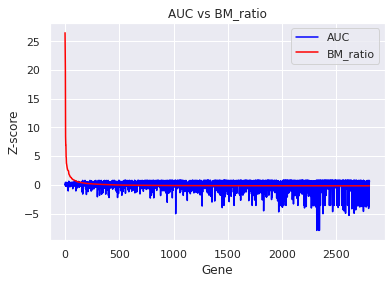

X is likely not normally distributed.
Y is likely not normally distributed.
The Kolmogorov-Smirnov test p-value: 0.0
The Wilcoxon test p-value: 4.806415126407657e-38
The Pearson correlation: 0.020053236871284286,
p-value: 0.28820086933630795


In [60]:
temp_data = full_mapped_ds.sort_values(by='bm_ratio', ascending=False)[['default_auc', 'bm_ratio']]
temp_data = calc_z_scores(temp_data)
auc = np.array(temp_data['default_auc'])
x = np.arange(auc.size)
bm_ratio = np.array(temp_data['bm_ratio'])
plt.plot(x, auc, c='blue', label = 'AUC')
plt.plot(x, bm_ratio, c='red', label='BM_ratio')
plt.legend()
plt.title('AUC vs BM_ratio')
plt.xlabel('Gene')
plt.ylabel('Z-score')
# plt.savefig()
plt.show()
perform_stats(auc, bm_ratio)

In [61]:
def do_stuff_but_not_allways():
    array_of_unique_genes = data['GeneName'].unique()

    genes_has_multiple_cats = pd.DataFrame(columns=['gene','auc'])
    genes_hasnot_multiple_cats = pd.DataFrame(columns=['gene','auc'])
    # These categories are from the Clinical Genomic Database
    category_feats = ['Allergy/Immunology/Infectious',
     'Audiologic/Otolaryngologic',
     'Biochemical',
     'Cardiovascular',
     'Craniofacial',
     'Dental',
     'Dermatologic',
     'Endocrine',
     'Gastrointestinal',
     'General',
     'Genitourinary',
     'Hematologic',
     'Musculoskeletal',
     'Neurologic',
     'Obstetric',
     'Oncologic',
     'Ophthalmologic',
     'Pulmonary',
     'Renal']

    for gene in array_of_unique_genes:
        subset_data = data[data['GeneName'] == gene]
        subset_data = subset_data[category_feats]
        try: 
            auc = full_mapped_ds[full_mapped_ds['gene'] == gene]['default_auc'].item()
        except ValueError:
            continue
        output = pd.DataFrame({'gene':gene,'auc':auc}, index=[0])
        if subset_data.any(axis=None):
            genes_has_multiple_cats = genes_has_multiple_cats.append(output, ignore_index=True)
        else:
            genes_hasnot_multiple_cats = genes_hasnot_multiple_cats.append(output, ignore_index=True)
    return genes_has_multiple_cats, genes_hasnot_multiple_cats

In [62]:
genes_has_multiple_cats, genes_hasnot_multiple_cats = do_stuff_but_not_allways()
genes_hasnot_multiple_cats_sorted = genes_hasnot_multiple_cats.sort_values(by='auc')
genes_has_multiple_cats_sorted = genes_has_multiple_cats.sort_values(by='auc')

In [63]:
n = genes_hasnot_multiple_cats_sorted[genes_hasnot_multiple_cats_sorted['auc'] < 0.6].shape[0]
tot = genes_hasnot_multiple_cats_sorted.shape[0]
pnmc = round(n/tot*100,ndigits=2)
print(f'No multiple categories has: {n} out of {tot} ({round(n/tot*100,ndigits=2)}%)')

No multiple categories has: 27 out of 224 (12.05%)


In [64]:
n = genes_has_multiple_cats_sorted[genes_has_multiple_cats_sorted['auc'] < 0.6].shape[0]
tot = genes_has_multiple_cats_sorted.shape[0]
pmc = round(n/tot*100,ndigits=2)
print(f'No multiple categories has: {n} out of {tot} ({round(n/tot*100,ndigits=2)}%)')

No multiple categories has: 66 out of 2544 (2.59%)


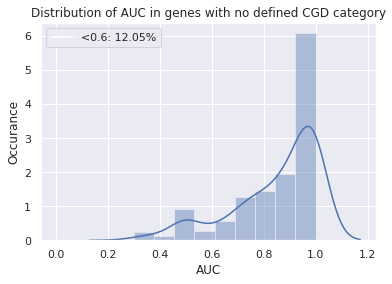

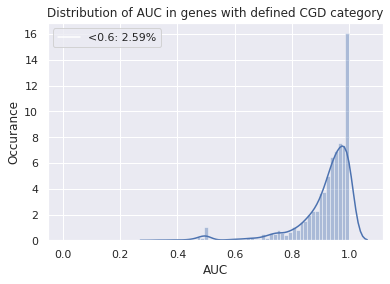

In [65]:
sns.distplot(np.array(genes_hasnot_multiple_cats_sorted['auc']))
plt.plot([0],[0],color='w', label=f'<0.6: {pnmc}%')
plt.title('Distribution of AUC in genes with no defined CGD category')
plt.ylabel('Occurance')
plt.xlabel('AUC')
plt.legend()
plt.savefig(img_output_dir+'distrubtion_auc_no_gcd_cat.png')
plt.show()
sns.distplot(np.array(genes_has_multiple_cats_sorted['auc']))
plt.plot([0],[0],color='w', label=f'<0.6: {pmc}%')
plt.title('Distribution of AUC in genes with defined CGD category')
plt.ylabel('Occurance')
plt.xlabel('AUC')
plt.legend()
plt.savefig(img_output_dir+'distrubtion_auc_gcd_cat.png')
plt.show()

# So, not really something there in terms of genes that do not have any boolean category to a tissue they belong to

Maybe something to add: the amount of pathways a gene is located in? The more pathways, the more pathogenic a variant should become in theory.

# On second thought, 27 out of 224 instead of 66 out of 2544 could be something

# Notes 23-04-2020
- Finish the final literature sources.
- Start of sprint 28-04-2020:
    - Find out what the categorical columns are within the training data.
    - Normalize BM ratio for gene length (bm ratio per 1000 bases or something)
    - Start working on the data sources to see if they are viable additions.
    - Start working on the missing values in the precomputed CAPICE scores.
    - Create outline for article (Title, Abstract, Introduction, Results, Conclusion/Discussion, Materials & Methods, Acknowledgements, Refereneces).
    - [Idea for clusterplot](https://docs.google.com/presentation/d/1_woKoD9nqWnxueyFYfwyX6B4owg8vYF7rw_nKpMPux4/edit#slide=id.p)

## EOS 23-04-2020
### Recap:
- Data analysis on input data (to see patterns and correlations, also to see what CAPICE uses the most to classify)
- Gather more data sources

### Done:
- PCA processed train data (too many columns, too complex)
- PCA cummulative variance explained
![](output_img/PCA.png)
- PCA projections on first 2 components
![](output_img/pca_2_comp.png)
- PCA projections on first 2 components with labels (issue = categorical data)
![](output_img/pca_first_2_comp_with_labels.png)
- BM_ratio ($\frac{n_{malign}}{n_{benign}} \times n_{total}$) (Normalized for gene length comming Soon)
![](output_img/bm_ratio.png)
- Distribution of genes that have a Clinical Genomic Database category
![](output_img/distrubtion_auc_gcd_cat.png)
- Distribution of genes that do not have a CGD category
![](output_img/distrubtion_auc_no_gcd_cat.png)

- Enrichr